# Изучение гипотезы построения модели прогнозирования землетрясений на с использованием сверточных нейронных сетей KERAS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from sklearn.metrics import classification_report, r2_score

from parser.db import client
from parser.repo.handler import upload_df
from datafactory.cuter import split_stratified_into_train_val_test
from datafactory.generator import Enrichment

2023-07-02 20:28:11.740243: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-02 20:28:11.741443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 20:28:11.769644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 20:28:11.770102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 20:28:12.350161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## 1. Загрузка данных

#### В базе данных созданы две таблицы 
- quakes - базовая таблица с данными. Данные загружены инструментами ноутбука **upload.ipynb**. В таблице значение магнитуды имеют дробные значения - тип данных FLOAT.
- quakes_class - в данной таблице значения магнитуды округлены до целых значений. Таким образом мы имеем до 10 классов магнитуды в диапазоне от 0 до 9, данная таблица, формируется программно на основе ранее загруженных данных из таблицы quakes.

В случае если, таблица данных **quakes_class** не загружена в базу данных, необходимо раскоментировать строку upload_quake_class_bd()

In [2]:
def upload_quake_class_bd():
    ### Создание базы данных с целыми значениями магнитуды
    quakes_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
    quakes_class_df = quakes_df.copy()
    quakes_class_df['Magnitude'] = np.round(quakes_class_df['Magnitude'], decimals = 0)
    upload_df(quakes_class_df, table='quakes_class')

upload_quake_class_bd()

None


In [3]:
# Загрузка данных
quakes_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
quakes_class_df: pd.DataFrame = client.query_df('SELECT * FROM quakes_class ORDER BY Date')

# Разбиение датасета на обучающий, валидационный и тестовый
df_train, df_val, df_test = split_stratified_into_train_val_test(quakes_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_features = df_train.copy()
test_features = df_test.copy()
val_features = df_val.copy()

train_labels = train_features.pop('Magnitude')
test_labels = test_features.pop('Magnitude')
val_labels = val_features.pop('Magnitude')

In [4]:
values_count = quakes_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')
values_count_class = quakes_class_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')

values_count_class['rate'] = 275374 / values_count_class['count']
values_count_class

,count,rate
Magnitude,,
2,34187,8.054933
3,275374,1.000000
4,188960,1.457314
5,71218,3.866635
6,6712,41.027116
7,502,548.553785
8,77,3576.285714
9,4,68843.500000


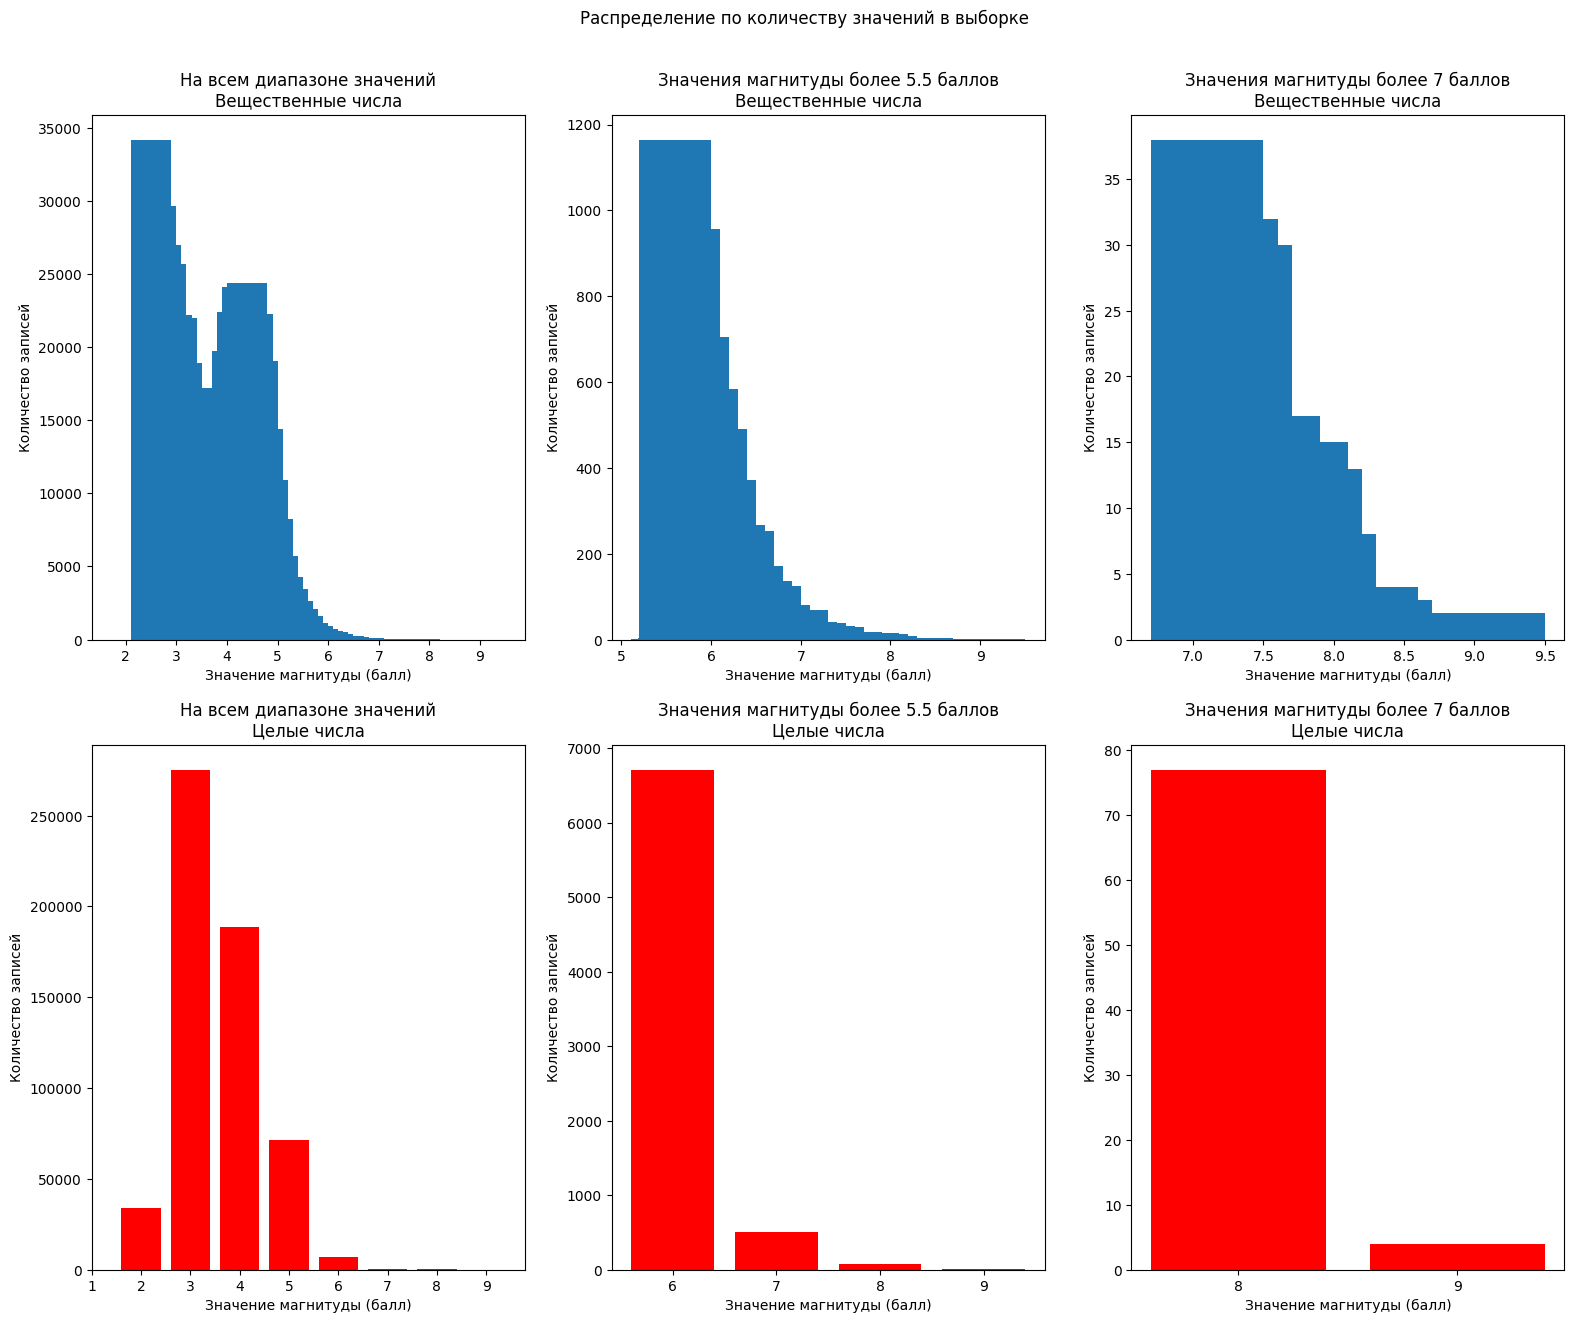

In [5]:
row, col = 2, 3

plt.figure(figsize=(19,15))
plt.suptitle('Распределение по количеству значений в выборке', y=0.95)

plt.subplot(row, col, 1)
plt.title('На всем диапазоне значений\nВещественные числа')
plt.bar(values_count.index.to_numpy(), values_count['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 2)
plt.title('Значения магнитуды более 5.5 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 5.5].index.to_numpy(), values_count[values_count.index > 5.5]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 3)
plt.title('Значения магнитуды более 7 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 7].index.to_numpy(), values_count[values_count.index > 7]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')


plt.subplot(row, col, 4)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class.index.to_numpy(), values_count_class['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 5)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 5.5].index.to_numpy(), values_count_class[values_count_class.index > 5.5]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 6)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 7].index.to_numpy(), values_count_class[values_count_class.index > 7]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])

plt.show()

На графике заметно значительное преобладание значений магнитуды от 2 до 5. Этот "Перекос", возможно, осложнит обучение модели в будущем. Решение этой проблемы будет приведено в разделе **3.1.**

## 2. Обучение моделей

### 2.1. Обучение модели регрессии на первичных данных, полученных из источника.


Нормализация признаков

In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

Построение модели. 

По результатам ряда попыток, с различными конфигурациями модели (разное количество слоев, разные значения units слоя), был сделан вывод, что для достижения относительно качественных показателей не требуется большое количество слоев и значений units слоя.

In [10]:
quake_model = keras.Sequential()

quake_model.add(normalizer)
quake_model.add(layers.Dense(3, activation='elu'))
quake_model.add(layers.Dense(1, activation='elu'))
quake_model.add(layers.Dense(1))

quake_model.summary()
quake_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error'],
)

Model: "sequential_1"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 58)                117       
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 3)                 177       
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 300 (1.18 KB)
Trainable params: 183 (732.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [11]:
history = quake_model.fit(
    train_features,
    train_labels,
    epochs=10,
    verbose=1,
    validation_data=(val_features.to_numpy(), val_labels.to_numpy())
)

Epoch 1/10
10820/10820 [==============================] - 9s 808us/step - loss: 0.9600 - mean_squared_error: 0.9600 - mean_absolute_percentage_error: 19.9987 - mean_absolute_error: 0.7077 - val_loss: 0.4329 - val_mean_squared_error: 0.4329 - val_mean_absolute_percentage_error: 14.8732 - val_mean_absolute_error: 0.5095
Epoch 2/10
10820/10820 [==============================] - 9s 790us/step - loss: 0.3928 - mean_squared_error: 0.3928 - mean_absolute_percentage_error: 13.8960 - mean_absolute_error: 0.4801 - val_loss: 0.3644 - val_mean_squared_error: 0.3644 - val_mean_absolute_percentage_error: 13.5244 - val_mean_absolute_error: 0.4644
Epoch 3/10
10820/10820 [==============================] - 8s 757us/step - loss: 0.3561 - mean_squared_error: 0.3561 - mean_absolute_percentage_error: 12.9933 - mean_absolute_error: 0.4512 - val_loss: 0.3497 - val_mean_squared_error: 0.3497 - val_mean_absolute_percentage_error: 12.9165 - val_mean_absolute_error: 0.4470
Epoch 4/10
10820/10820 [================

#### 2.1.1 Изучение результатов

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,val_mean_absolute_error,epoch
5,0.336936,0.336936,12.395633,0.429642,0.336464,0.336464,12.361523,0.427950,5
6,0.335087,0.335087,12.336296,0.427343,0.334843,0.334843,12.293554,0.426748,6
7,0.333767,0.333767,12.301067,0.426025,0.333777,0.333777,12.314518,0.426554,7
8,0.332800,0.332800,12.276623,0.425093,0.333387,0.333387,12.120776,0.421984,8
9,0.331977,0.331977,12.259786,0.424476,0.333176,0.333176,12.259662,0.424240,9


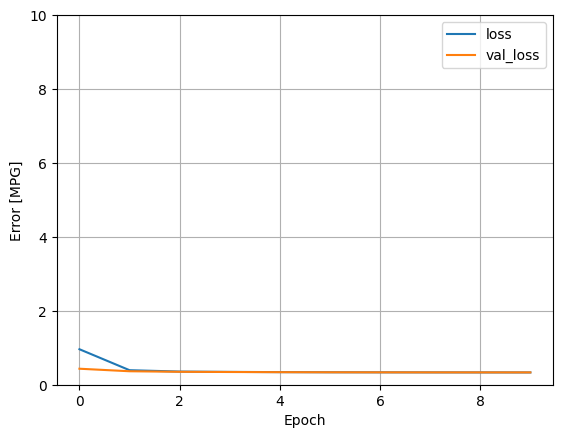

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [14]:
y_pred = quake_model.predict(test_features)
r2_score(test_labels.to_numpy(), y_pred)

4509/4509 [==============================] - 2s 451us/step


0.5254362236028003

### 2.2. Обучение модели классификации, на преобразованных данных.

#### Подготовка обучающей, валидационной и тестовой выборок.

Для моделей классификации необходима процедура преобразования массива ответов. Преобразование происходит с помощью функции keras.utils - **to_categorical()**

In [15]:
# Разбиение датасета на обучающий, валидационный и тестовый
df_class_train, df_class_val, df_class_test = split_stratified_into_train_val_test(quakes_class_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_class_features = df_class_train.copy()
test_class_features = df_class_val.copy()
val_class_features = df_class_test.copy()

train_labels = train_class_features.pop('Magnitude')
test_labels = test_class_features.pop('Magnitude')
val_labels = val_class_features.pop('Magnitude')

nb_classes = 10
y_train = to_categorical(train_labels.to_numpy().astype(int), nb_classes)
y_test = to_categorical(test_labels.to_numpy().astype(int), nb_classes)
y_val = to_categorical(val_labels.to_numpy().astype(int), nb_classes)

normalizer_class = tf.keras.layers.Normalization(axis=-1)
normalizer_class.adapt(np.array(train_class_features))

Построение модели. 

По результатам ряда попыток, с различными конфигурациями модели (разное количество слоев, разные значения units слоя), был сделан вывод, что для достижения относительно качественных показателей не требуется большое количество слоев и значений units слоя.

Функция активации последнего слоя в случае применения sigmoid и softmax показала сопоставимое качество модели.

In [16]:
quake_class_model = keras.Sequential()

quake_class_model.add(normalizer_class)
quake_class_model.add(layers.Dense(3, activation='relu'))
quake_class_model.add(layers.Dense(1, activation='relu'))
quake_class_model.add(layers.Dense(nb_classes, activation='softmax'))

quake_class_model.summary()
quake_class_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', [Recall(), Precision(), F1Score()]]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 58)                117       
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 3)                 177       
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
 dense_8 (Dense)             (None, 10)                20        
                                                                 
Total params: 318 (1.25 KB)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [17]:
history = quake_class_model.fit(
    train_class_features,
    y_train,
    epochs=10,
    verbose=1,
    validation_data=(val_class_features.to_numpy(), y_val)
)

Epoch 1/10
10820/10820 [==============================] - 10s 899us/step - loss: 1.0384 - accuracy: 0.6197 - recall: 0.4448 - precision: 0.6729 - f1_score: 0.1320 - val_loss: 0.9342 - val_accuracy: 0.6428 - val_recall: 0.5703 - val_precision: 0.6639 - val_f1_score: 0.1389
Epoch 2/10
10820/10820 [==============================] - 10s 890us/step - loss: 0.9267 - accuracy: 0.6453 - recall: 0.5804 - precision: 0.6648 - f1_score: 0.1386 - val_loss: 0.9315 - val_accuracy: 0.6408 - val_recall: 0.5820 - val_precision: 0.6611 - val_f1_score: 0.1380
Epoch 3/10
10820/10820 [==============================] - 10s 951us/step - loss: 0.9242 - accuracy: 0.6464 - recall: 0.5846 - precision: 0.6651 - f1_score: 0.1387 - val_loss: 0.9281 - val_accuracy: 0.6438 - val_recall: 0.5853 - val_precision: 0.6615 - val_f1_score: 0.1384
Epoch 4/10
10820/10820 [==============================] - 10s 909us/step - loss: 0.9234 - accuracy: 0.6463 - recall: 0.5869 - precision: 0.6653 - f1_score: 0.1387 - val_loss: 0.9298

#### 2.2.1 Изучение результатов

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,recall,precision,f1_score,val_loss,val_accuracy,val_recall,val_precision,val_f1_score,epoch
5,0.922574,0.647031,0.588230,0.665750,"[0.0, 0.0, 0.0, 0.787188, 0.6014684, 0.0, 0.0,...",0.928456,0.642830,0.591616,0.660256,"[0.0, 0.0, 0.0, 0.7854746, 0.5924829, 0.0, 0.0...",5
6,0.922282,0.647195,0.588574,0.665717,"[0.0, 0.0, 0.0, 0.78756976, 0.6011566, 0.0, 0....",0.928980,0.641929,0.583125,0.663457,"[0.0, 0.0, 0.0, 0.7821845, 0.6035882, 0.0, 0.0...",6
7,0.922147,0.647357,0.589279,0.665916,"[0.0, 0.0, 0.0, 0.78739613, 0.6020407, 0.0, 0....",0.928103,0.644674,0.586438,0.661778,"[0.0, 0.0, 0.0, 0.7868109, 0.596921, 0.0, 0.0,...",7
8,0.921934,0.647487,0.589394,0.665766,"[0.0, 0.0, 0.0, 0.78759474, 0.6019339, 0.0, 0....",0.928186,0.643066,0.583139,0.661943,"[0.0, 0.0, 0.0, 0.7833428, 0.6041543, 0.0, 0.0...",8
9,0.921760,0.647169,0.589530,0.666111,"[0.0, 0.0, 0.0, 0.78742987, 0.6012212, 0.0, 0....",0.927345,0.643891,0.579610,0.662725,"[0.0, 0.0, 0.0, 0.7845664, 0.6047906, 0.0, 0.0...",9


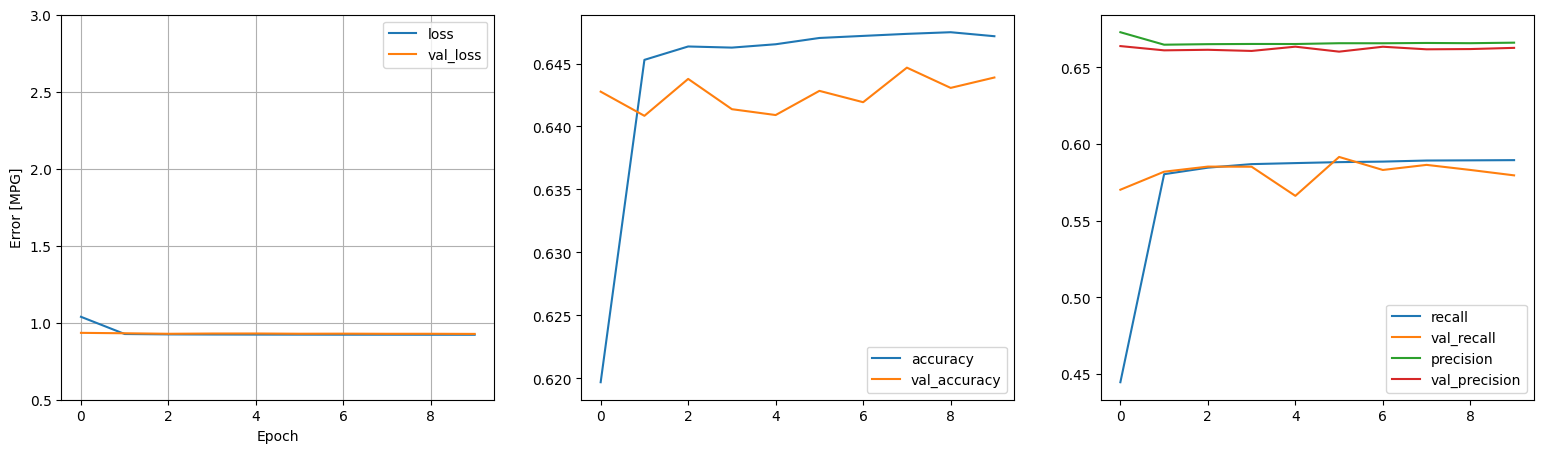

In [19]:
def plot_loss(history, num = ''):
    plt.figure(figsize=(19,5))
    row, col = 1, 3
    plt.subplot(row, col, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0.5, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

    plt.subplot(row, col, 2)
    #plt.ylim([0.475, 0.480])
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()

    plt.subplot(row, col, 3)
    
    plt.plot(history.history[f'recall{num}'], label='recall')
    plt.plot(history.history[f'val_recall{num}'], label='val_recall')
    plt.plot(history.history[f'precision{num}'], label='precision')
    plt.plot(history.history[f'val_precision{num}'], label='val_precision')
    plt.legend()

plot_loss(history)

Посмотрим какие присутствуют ответы

In [20]:
y_pred = quake_class_model.predict(test_class_features)

answer = []
for row in y_pred:
    answer.append(np.argmax(row))

np.unique(np.array(answer))

2705/2705 [==============================] - 1s 480us/step


array([3, 4])

In [21]:
print(classification_report(test_labels, answer))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00      5110
           3       0.69      0.91      0.79     41204
           4       0.57      0.65      0.60     28329
           5       0.00      0.00      0.00     10804
           6       0.00      0.00      0.00      1021
           7       0.00      0.00      0.00        77
           8       0.00      0.00      0.00        10

    accuracy                           0.65     86555
   macro avg       0.18      0.22      0.20     86555
weighted avg       0.51      0.65      0.57     86555



/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

# 3. Обучение модели на равномерно распределенных данных

## 3.1. Обогащение данных датасета

Цель обогащения - достичь сопоставимого количества событий в каждой группе. Для обогащения в каждой группе каждое событие увеличивается в кратное количество раз:
- дата события не меняется
- координаты распределяются в диапазоне 0,5 градуса долготы исходного события.

Правило кратности для каждой группы заносятся в словарь **enrich_rule**

In [22]:
import time
start_time = time.time()

enrich_rule = {
    2: 2,
    6: 20,
    7: 100,
    8: 500,
    9: 1000,
}

table = 'quakes_class'
column = 'Magnitude'

for magnitude, new_incident_count in enrich_rule.items():
    print(f'start enrich for {magnitude} magnitude up to {new_incident_count} new rows in one incident')

    enrichment = Enrichment(table, column, magnitude, new_incident_count)
    upload_df(enrichment.start_add(), table=table)

    end_time = time.time()
    delta = (end_time  - start_time) / 60
    print(f'finish enrich for {magnitude} magnitude in {delta} min')
    start_time = end_time

start enrich for 2 magnitude up to 2 new rows in one incident
None
finish enrich for 2 magnitude in 9.444365843137104 min
start enrich for 6 magnitude up to 20 new rows in one incident
None
finish enrich for 6 magnitude in 2.410525214672089 min
start enrich for 7 magnitude up to 100 new rows in one incident
None
finish enrich for 7 magnitude in 0.11173042456309 min
start enrich for 8 magnitude up to 500 new rows in one incident
None
finish enrich for 8 magnitude in 0.05645534594853719 min
start enrich for 9 magnitude up to 1000 new rows in one incident
None
finish enrich for 9 magnitude in 0.0045730193456014 min


Загрузка обогащенных данных

In [23]:
quakes_class_df_enrich: pd.DataFrame = client.query_df('SELECT * FROM quakes_class ORDER BY Date')

values_count_class = quakes_class_df_enrich['Magnitude'].value_counts().to_frame().sort_values('Magnitude')

values_count_class['rate'] = 275374 / values_count_class['count']
values_count_class

,count,rate
Magnitude,,
2,136748,2.013733
3,275374,1.000000
4,188960,1.457314
5,71218,3.866635
6,147664,1.864869
7,51204,5.377978
8,38654,7.124075
9,4008,68.706088


Просмотр результата

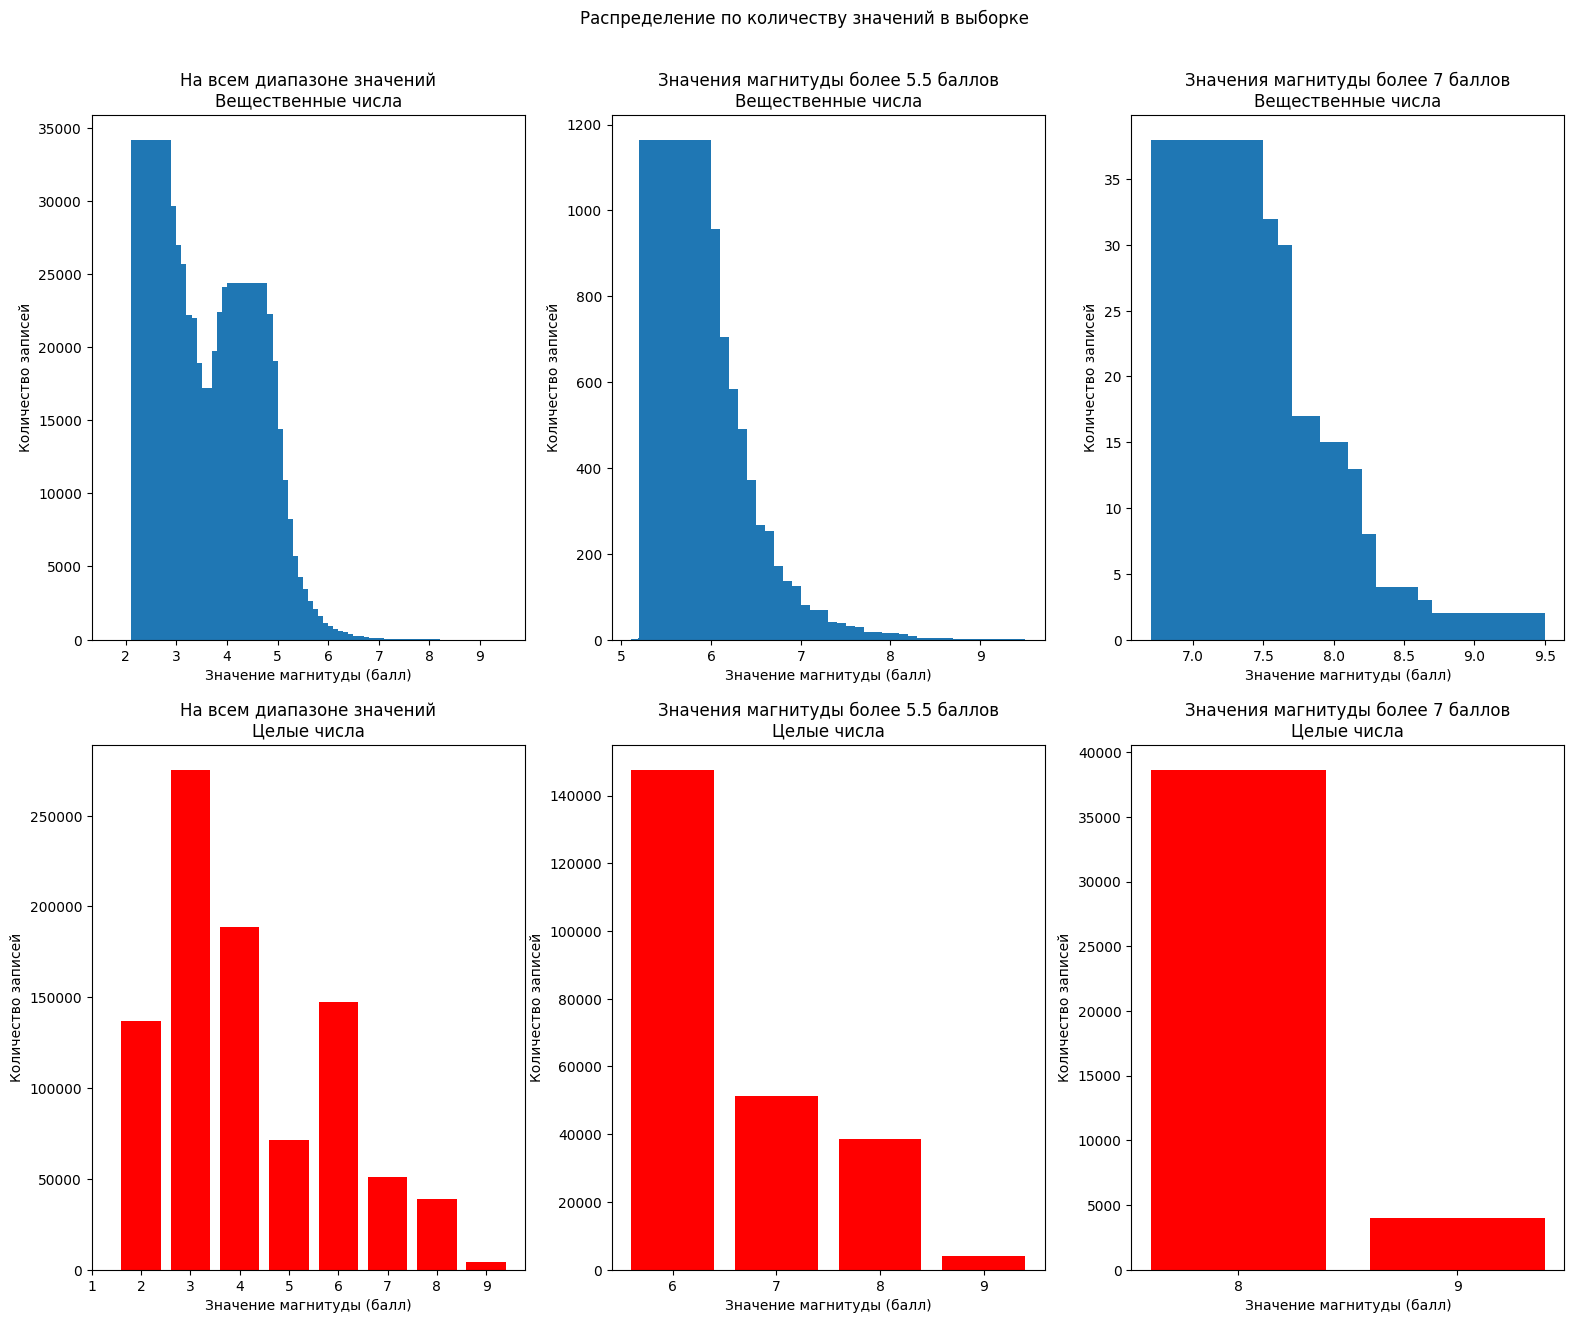

In [24]:
row, col = 2, 3
plt.figure(figsize=(19,15))
plt.suptitle('Распределение по количеству значений в выборке', y=0.95)

plt.subplot(row, col, 1)
plt.title('На всем диапазоне значений\nВещественные числа')
plt.bar(values_count.index.to_numpy(), values_count['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 2)
plt.title('Значения магнитуды более 5.5 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 5.5].index.to_numpy(), values_count[values_count.index > 5.5]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 3)
plt.title('Значения магнитуды более 7 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 7].index.to_numpy(), values_count[values_count.index > 7]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')


plt.subplot(row, col, 4)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class.index.to_numpy(), values_count_class['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 5)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 5.5].index.to_numpy(), values_count_class[values_count_class.index > 5.5]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 6)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 7].index.to_numpy(), values_count_class[values_count_class.index > 7]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])

plt.show()

Подготовка данных для обучения

In [25]:
# Разбиение датасета на обучающий, валидационный и тестовый
df_class_train, df_class_val, df_class_test = split_stratified_into_train_val_test(quakes_class_df_enrich.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_class_features = df_class_train.copy()
test_class_features = df_class_val.copy()
val_class_features = df_class_test.copy()

train_labels = train_class_features.pop('Magnitude')
test_labels = test_class_features.pop('Magnitude')
val_labels = val_class_features.pop('Magnitude')

nb_classes = 10
y_train = to_categorical(train_labels.to_numpy().astype(int), nb_classes)
y_test = to_categorical(test_labels.to_numpy().astype(int), nb_classes)
y_val = to_categorical(val_labels.to_numpy().astype(int), nb_classes)

normalizer_class = tf.keras.layers.Normalization(axis=-1)
normalizer_class.adapt(np.array(train_class_features))

Подготовка модели

In [26]:
quake_class_model = keras.Sequential()

quake_class_model.add(normalizer_class)
quake_class_model.add(layers.Dense(3, activation='relu'))
quake_class_model.add(layers.Dense(1, activation='relu'))
quake_class_model.add(layers.Dense(nb_classes, activation='softmax'))

quake_class_model.summary()
quake_class_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', [Recall(), Precision(), F1Score()]]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 58)                117       
 tion)                                                           
                                                                 
 dense_9 (Dense)             (None, 3)                 177       
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
 dense_11 (Dense)            (None, 10)                20        
                                                                 
Total params: 318 (1.25 KB)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [27]:
history = quake_class_model.fit(
    train_class_features,
    y_train,
    epochs=10,
    verbose=1,
    validation_data=(val_class_features.to_numpy(), y_val)
)

Epoch 1/10
17135/17135 [==============================] - 16s 897us/step - loss: 1.5301 - accuracy: 0.4057 - recall_1: 0.1446 - precision_1: 0.4996 - f1_score: 0.1295 - val_loss: 1.4771 - val_accuracy: 0.4167 - val_recall_1: 0.2103 - val_precision_1: 0.5005 - val_f1_score: 0.1337
Epoch 2/10
17135/17135 [==============================] - 15s 884us/step - loss: 1.4741 - accuracy: 0.4149 - recall_1: 0.2087 - precision_1: 0.4989 - f1_score: 0.1337 - val_loss: 1.4727 - val_accuracy: 0.4156 - val_recall_1: 0.2137 - val_precision_1: 0.5014 - val_f1_score: 0.1335
Epoch 3/10
17135/17135 [==============================] - 15s 884us/step - loss: 1.4711 - accuracy: 0.4158 - recall_1: 0.2123 - precision_1: 0.4988 - f1_score: 0.1341 - val_loss: 1.4718 - val_accuracy: 0.4155 - val_recall_1: 0.2101 - val_precision_1: 0.4994 - val_f1_score: 0.1342
Epoch 4/10
17135/17135 [==============================] - 16s 913us/step - loss: 1.4701 - accuracy: 0.4159 - recall_1: 0.2144 - precision_1: 0.5000 - f1_scor

### 3.1.1. Изучение результатов

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,recall_1,precision_1,f1_score,val_loss,val_accuracy,val_recall_1,val_precision_1,val_f1_score,epoch
5,1.468883,0.415993,0.215359,0.500364,"[0.0, 0.0, 0.0, 0.6360895, 0.35507706, 0.0, 0....",1.470486,0.415932,0.216565,0.502407,"[0.0, 0.0, 0.0, 0.63331866, 0.3357847, 0.0, 0....",5
6,1.468430,0.415765,0.216711,0.501308,"[0.0, 0.0, 0.0, 0.635884, 0.35391116, 0.0, 0.3...",1.469516,0.416510,0.216079,0.501397,"[0.0, 0.0, 0.0, 0.6355794, 0.34508374, 0.0, 0....",6
7,1.468294,0.416259,0.216448,0.501089,"[0.0, 0.0, 0.0, 0.63607043, 0.354501, 0.0, 0.3...",1.469280,0.416225,0.218535,0.502921,"[0.0, 0.0, 0.0, 0.63590986, 0.3534638, 0.0, 0....",7
8,1.467944,0.415765,0.217105,0.501608,"[0.0, 0.0, 0.0, 0.6358528, 0.35353586, 0.0, 0....",1.468742,0.416842,0.218031,0.503070,"[0.0, 0.0, 0.0, 0.6365233, 0.35824376, 0.0, 0....",8
9,1.467756,0.415996,0.217055,0.501445,"[0.0, 0.0, 0.0, 0.6359563, 0.35396376, 0.0, 0....",1.468167,0.416672,0.216219,0.502135,"[0.0, 0.0, 0.0, 0.636216, 0.36321327, 0.0, 0.3...",9


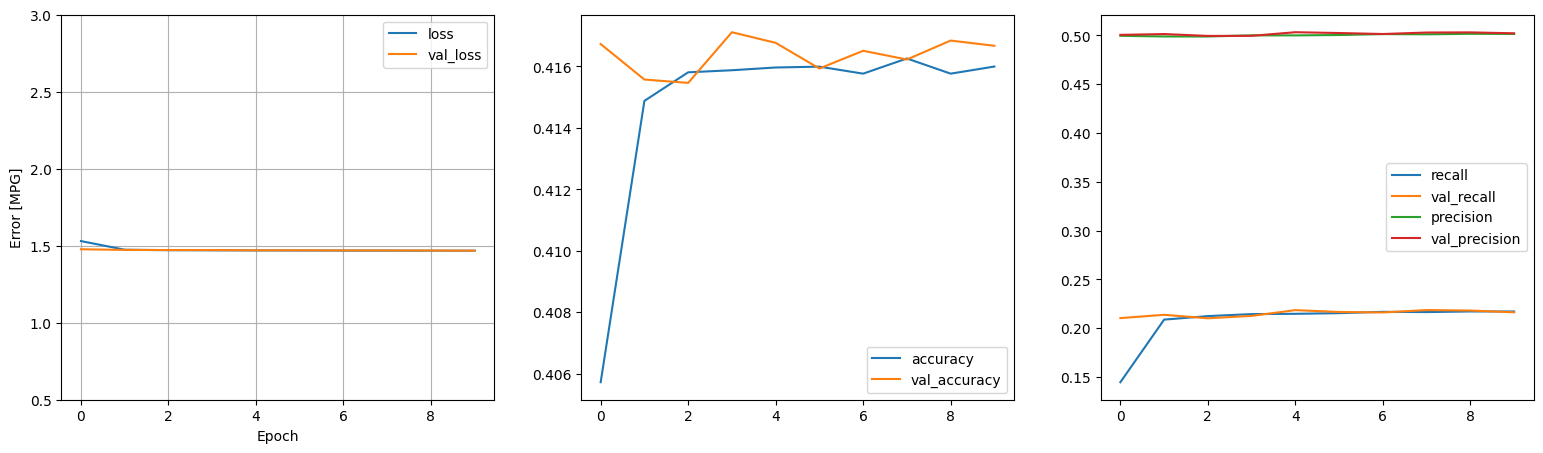

In [30]:
plot_loss(history, '_1')

In [31]:
y_pred = quake_class_model.predict(test_class_features)

answer = []
for row in y_pred:
    answer.append(np.argmax(row))

np.unique(np.array(answer))

4284/4284 [==============================] - 2s 494us/step


array([3, 4, 6, 9])

In [32]:
print(classification_report(test_labels, answer))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00     20585
           3       0.49      0.90      0.64     41244
           4       0.31      0.44      0.37     28304
           5       0.00      0.00      0.00     10611
           6       0.34      0.34      0.34     22194
           7       0.00      0.00      0.00      7731
           8       0.00      0.00      0.00      5811
           9       0.00      0.00      0.00       594

    accuracy                           0.42    137074
   macro avg       0.14      0.21      0.17    137074
weighted avg       0.27      0.42      0.32    137074



/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression # Импортируем класс LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X = np.array([[5, 10, 25, 40, 50, 60], [502, 502, 502, 502, 502, 502]]) # Значения признака
y = np.array([3.8, 10, 30.6, 67.6, 96, 143]) # Значение целевой переменной

X_ = X.reshape(-1,1) # Преобразуем X
reg = Pipeline([('quad', PolynomialFeatures(degree=3)),
                ('lr', LinearRegression())]) # Создаем экземпляр класса
reg.fit(X.T, y) # Обучаем
reg.score(X.T, y) # Оценка качества

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[0,:], X[1,:], y)

In [ ]:
pred = reg.predict(np.array([[100], [502]]).T)
pred[0] / 60

In [ ]:
import pandas as pd


frame = pd.concat([pd.DataFrame([[1, 'd', 2.0]])] * 10, ignore_index=True)
frame

In [ ]:
[0] * 10

In [ ]:
frame[1] = [0] * 10

In [ ]:
frame